In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import urllib.request
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv", filename="finance_data.csv")

('finance_data.csv', <http.client.HTTPMessage at 0x7ff00e23bb90>)

In [13]:
data = pd.read_csv('finance_data.csv')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4846


In [14]:
data

,lables,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,런던 마켓워치 -- 은행주의 반등이 FTSE 100지수의 약세를 상쇄하지 못하면서 ...
4842,neutral,Rinkuskiai's beer sales fell by 6.5 per cent t...,린쿠스키아의 맥주 판매량은 416만 리터로 6.5% 감소했으며 카우노 알루스의 맥주...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,"영업이익은 2007년 68.8 mn에서 35.4 mn으로 떨어졌으며, 선박 판매 이..."
4844,negative,Net sales of the Paper segment decreased to EU...,페이퍼 부문 순매출은 2008년 2분기 241.1 mn에서 2009년 2분기 221...


In [15]:
data['lables'] = data['lables'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
data[:5]

,lables,sentence,kor_sentence
0,0,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [16]:
del data['kor_sentence']

In [17]:
data[:5]

,lables,sentence
0,0,"According to Gran, the company has no plans to..."
1,0,Technopolis plans to develop in stages an area...
2,2,The international electronic industry company ...
3,1,With the new production plant the company woul...
4,1,According to the company's updated strategy fo...


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lables    4846 non-null   int64 
 1   sentence  4846 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [19]:
print('결측값 여부 :',data.isnull().values.any())

결측값 여부 : False


In [22]:
print('sentence 열의 유니크한 값 :',data['sentence'].nunique())

sentence 열의 유니크한 값 : 4838


In [23]:
duplicate = data[data.duplicated()]

In [24]:
duplicate

,lables,sentence
1099,0,The issuer is solely responsible for the conte...
1416,0,The report profiles 614 companies including ma...
2396,0,Ahlstrom's share is quoted on the NASDAQ OMX H...
2567,0,SSH Communications Security Corporation is hea...
3094,0,Proha Plc ( Euronext :7327 ) announced today (...
3206,0,The company serves customers in various indust...


In [26]:
# 중복 제거
data.drop_duplicates(subset=['sentence'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4838


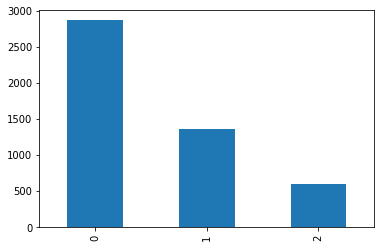

In [27]:
data['lables'].value_counts().plot(kind='bar')

In [28]:
print('레이블의 분포')
print(data.groupby('lables').size().reset_index(name='count'))

레이블의 분포
   lables  count
0       0   2872
1       1   1362
2       2    604


In [29]:
print(f'중립의 비율 = {round(data["lables"].value_counts()[0]/len(data) * 100,3)}%')
print(f'긍정의 비율 = {round(data["lables"].value_counts()[1]/len(data) * 100,3)}%')
print(f'부정의 비율 = {round(data["lables"].value_counts()[2]/len(data) * 100,3)}%')

중립의 비율 = 59.363%
긍정의 비율 = 28.152%
부정의 비율 = 12.484%


In [31]:
data

,lables,sentence
0,0,"According to Gran, the company has no plans to..."
1,0,Technopolis plans to develop in stages an area...
2,2,The international electronic industry company ...
3,1,With the new production plant the company woul...
4,1,According to the company's updated strategy fo...
...,...,...
4841,2,LONDON MarketWatch -- Share prices ended lower...
4842,0,Rinkuskiai's beer sales fell by 6.5 per cent t...
4843,2,Operating profit fell to EUR 35.4 mn from EUR ...
4844,2,Net sales of the Paper segment decreased to EU...


In [32]:
X_data = data['sentence']
y_data = data['lables']
print('본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

본문의 개수: 4838
레이블의 개수: 4838


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [34]:
print('훈련 샘플의 개수 :', len(X_train))
print('테스트 샘플의 개수 :', len(X_test))

훈련 샘플의 개수 : 3870
테스트 샘플의 개수 : 968


In [35]:
print('--------훈련 데이터의 비율-----------')
print(f'중립 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'긍정 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print(f'부정 = {round(y_train.value_counts()[2]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
중립 = 59.354%
긍정 = 28.165%
부정 = 12.481%


In [36]:
print('--------테스트 데이터의 비율-----------')
print(f'중립 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'긍정 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')
print(f'부정 = {round(y_test.value_counts()[2]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
중립 = 59.401%
긍정 = 28.099%
부정 = 12.5%


In [37]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)
print(X_train_encoded[:5])
print(X_test_encoded[:5])

[[981, 9, 587, 12, 1, 249, 196, 3, 70], [982, 1, 1397, 99, 794, 3, 350, 380, 9, 60, 1561, 1, 254, 1049, 4468, 59, 4469, 263, 3, 1, 1143, 2, 2435, 90, 1050, 4, 1144, 105, 161, 254, 4470], [1, 3088, 9, 3, 2025, 1051, 1, 121, 2, 1, 365, 186, 351, 454, 4, 4471, 1, 3088, 5, 624, 407, 66, 852, 17, 1, 351, 454, 472, 12, 216, 41, 53], [1, 222, 2436, 9, 3089, 3, 6, 269, 4472, 3090, 15, 6, 4473, 983], [70, 984, 80, 503, 4474, 1398, 162, 29, 3, 14, 65, 52, 266, 12, 705, 26, 985, 3, 14, 2437, 48, 3, 352, 59, 9, 2438, 1745, 217, 1, 65, 52]]
[[38, 2, 1, 2636, 1097, 17, 1, 723, 259, 19, 6, 277, 3045, 9, 2512, 2, 19, 4061], [451, 4453, 33, 687, 3, 2149, 3, 1, 1440, 2, 4453, 284, 4, 9, 106, 2, 451, 153, 504, 394, 243, 521, 3, 1, 686, 2398, 534], [1, 883, 9, 1451, 24, 8596, 26, 338, 853, 4, 64, 55, 3, 35], [1, 50, 60, 16, 6, 541, 175, 397, 3, 95, 1234, 7949], [3, 376, 981, 165, 6, 142, 31, 379, 81, 7, 1, 2753]]


In [38]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(vocab_size)

9348


본문의 최대 길이 : 302
본문의 평균 길이 : 125.91602067183463


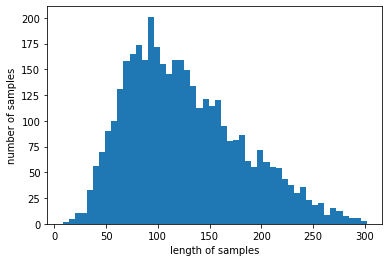

In [39]:
print('본문의 최대 길이 :',max(len(sent) for sent in X_train))
print('본문의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(sent) for sent in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [40]:
max_len = 302

In [41]:
X_train_encoded = pad_sequences(X_train_encoded, maxlen=max_len)
X_test_encoded = pad_sequences(X_test_encoded, maxlen=max_len)

In [42]:
X_train_encoded.shape

(3870, 302)

In [43]:
X_test_encoded.shape

(968, 302)

In [44]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [45]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [46]:
embedding_dim = 64
hidden_units = 64
num_classes = 3

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train_encoded, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/15
97/97 [==============================] - ETA: 0s - loss: 0.8860 - acc: 0.6134
Epoch 00001: val_acc improved from -inf to 0.64083, saving model to best_model.h5
97/97 [==============================] - 6s 20ms/step - loss: 0.8860 - acc: 0.6134 - val_loss: 0.7715 - val_acc: 0.6408
Epoch 2/15
97/97 [==============================] - ETA: 0s - loss: 0.6097 - acc: 0.7364
Epoch 00002: val_acc improved from 0.64083 to 0.71318, saving model to best_model.h5
97/97 [==============================] - 1s 15ms/step - loss: 0.6097 - acc: 0.7364 - val_loss: 0.7035 - val_acc: 0.7132
Epoch 3/15
97/97 [==============================] - ETA: 0s - loss: 0.3214 - acc: 0.8915
Epoch 00003: val_acc improved from 0.71318 to 0.71705, saving model to best_model.h5
97/97 [==============================] - 1s 15ms/step - loss: 0.3214 - acc: 0.8915 - val_loss: 0.7717 - val_acc: 0.7171
Epoch 4/15
97/97 [==============================] - ETA: 0s - loss: 0.1348 - acc: 0.9587
Epoch 00004: val_acc improved fr

In [47]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test_encoded, y_test)[1]))

31/31 [==============================] - 1s 6ms/step - loss: 0.7272 - acc: 0.7738

 테스트 정확도: 0.7738
